In [1]:
        import matplotlib.pylab as plt
import numpy as np
plt.style.use("/afs/ihep.ac.cn/users/l/luoxj/Style/Paper.mplstyle")
%config InlineBackend.figure_format = 'svg'
#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
import sys
sys.path.append("/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/")
from LoadMultiFiles import LoadMultiFilesMultiProcess
from LoadMultiFiles import LoadMultiROOTFiles

# v_BeamEnergy = ["30MeV", "100MeV", "500MeV"]
v_BeamEnergy = ["500MeV"]

dir_PMT_diff_BeamE = {}
list_branch_filter = ["step_x", "step_y", "step_z"]
for BeamE in v_BeamEnergy:
    dir_PMT_diff_BeamE[BeamE] = LoadMultiROOTFiles(f"/afs/ihep.ac.cn/users/l/luoxj/JUNO_G4_Simulation/optical_run/proton/root/proton_{BeamE}_*.root",
                            name_branch="PMT_log", list_branch_filter=list_branch_filter)

/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/LoadMultiFiles.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  dir_events[key] = np.array(dir_events[key])


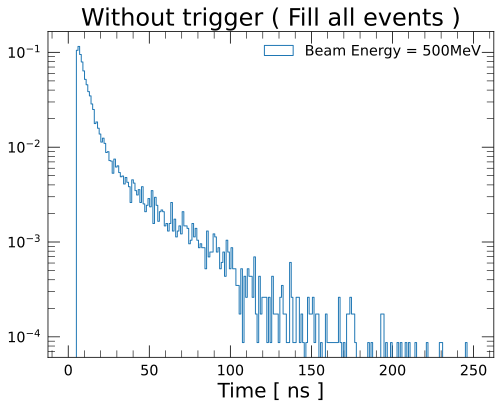

In [2]:
for beamE, dir_PMT in dir_PMT_diff_BeamE.items():
    plt.hist(np.concatenate(dir_PMT["step_t"])[np.concatenate(dir_PMT["step_chamberID"])==1], bins=np.linspace(0,250,250),
             histtype="step", label="Beam Energy = "+beamE, density=True)
    plt.title("Without trigger ( Fill all events )")
    plt.xlabel("Time [ ns ]")
    plt.semilogy()
    plt.legend()

In [3]:
from collections import Counter
dir_hits_PMT_near = {}
for beamE, dir_PMT in dir_PMT_diff_BeamE.items():
    v_n_hits_PMT_near = []
    v_n_cerenkov = []
    v_P_cerenkov = []
    for i_evt in range(len(dir_PMT["step_chamberID"])):
        index_PMT_near = dir_PMT["step_chamberID"][i_evt]==0
        n_hits = Counter(index_PMT_near)[True]
        v_n_hits_PMT_near.append(n_hits)
        n_cerenkov = Counter(dir_PMT["step_isCherenkov"][i_evt][index_PMT_near]==1)[True]
        v_n_cerenkov.append(n_cerenkov)
        v_P_cerenkov.append(n_cerenkov/n_hits)
    dir_hits_PMT_near[beamE+"NofHits"] = np.array(v_n_hits_PMT_near)
    dir_hits_PMT_near[beamE+"isCerenkov"] = np.array(v_n_cerenkov)
    dir_hits_PMT_near[beamE+"PCerenkov"] = np.array(v_P_cerenkov)


[]

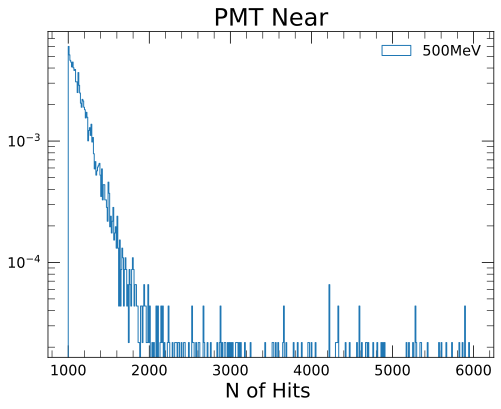

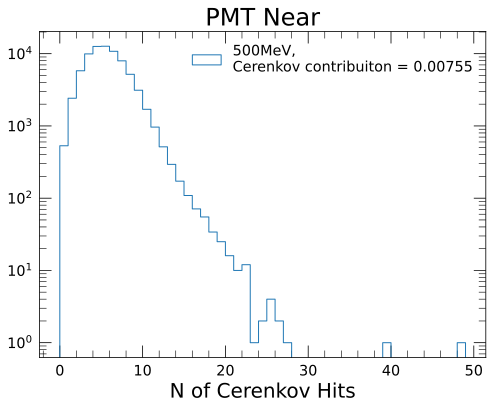

In [4]:

for beamE in v_BeamEnergy:
    plt.hist(dir_hits_PMT_near[beamE+"NofHits"], bins=np.linspace(1000,6000, 500), histtype="step",
             density=True, label=beamE)
plt.xlabel("N of Hits ")
plt.semilogy()
plt.title("PMT Near")
plt.legend()


plt.figure()
for beamE in v_BeamEnergy:
    plt.hist(dir_hits_PMT_near[beamE+"isCerenkov"], bins=range(50),
             histtype="step",label=beamE+f",\nCerenkov contribuiton = {np.mean(dir_hits_PMT_near[beamE+'PCerenkov']):.3g}")
plt.legend()
plt.title("PMT Near")
plt.xlabel("N of Cerenkov Hits")
plt.semilogy()



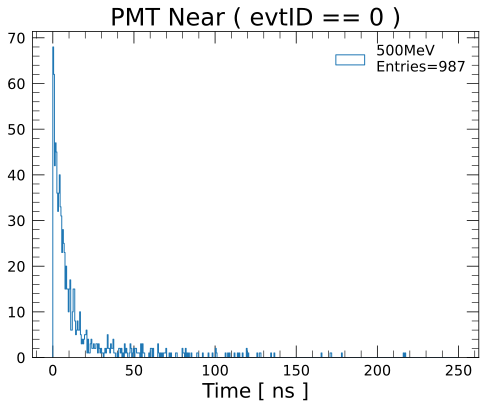

In [5]:
i_evt = 0
for beamE, dir_PMT in dir_PMT_diff_BeamE.items():
    index_PMT_near = dir_PMT["step_chamberID"][i_evt]==0
    plt.hist(dir_PMT["step_t"][i_evt][index_PMT_near],bins=np.linspace(0,250,500),histtype="step",
             label=beamE+f"\nEntries={len(dir_PMT['step_t'][i_evt][index_PMT_near])}")
plt.title("PMT Near ( evtID == 0 )")
plt.xlabel("Time [ ns ]")
# plt.semilogy()
plt.legend()


# Using near PMT to get trigger

## t0 Distribution

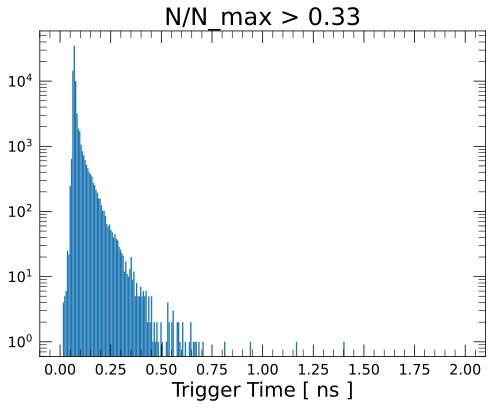

In [6]:
from HistTools import GetBinCenter
n_hits_threshold = 1./3.
bins_time =np.linspace(0,2, 300)
for beamE, dir_PMT in dir_PMT_diff_BeamE.items():
    v_t0 = []
    for i_evt in range(len(dir_PMT["evtID"])):
        index_PMT_near = (dir_PMT["step_chamberID"][i_evt]==0)
        h_time_near = np.histogram(dir_PMT["step_t"][i_evt][index_PMT_near], bins=bins_time)
        if np.all(h_time_near[0]==0):
            continue
        trigger_time = GetBinCenter(h_time_near[1])[h_time_near[0]/np.max(h_time_near[0])>n_hits_threshold][0]
        v_t0.append(trigger_time)
    plt.hist(v_t0,bins=bins_time)
    plt.semilogy()
    plt.xlabel("Trigger Time [ ns ]")
    plt.title(f"N/N_max > {n_hits_threshold:.2g}")



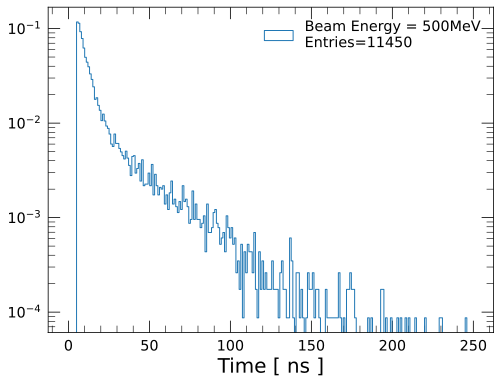

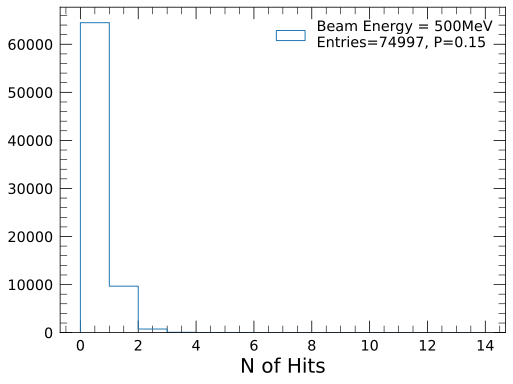

In [7]:
dir_v_time = {}

for beamE, dir_PMT in dir_PMT_diff_BeamE.items():
    v_emission_time = []
    v_n_hits = []
    for i_evt in range(len(dir_PMT["evtID"])):
        index_PMT_near = (dir_PMT["step_chamberID"][i_evt]==0)
        index_PMT_far = (dir_PMT["step_chamberID"][i_evt]==1)
        if np.any(index_PMT_far)==False:
            v_n_hits.append(0)
            continue
        h_time_near = np.histogram(dir_PMT["step_t"][i_evt][index_PMT_near], bins=np.linspace(0,20, 100))
        trigger_time = GetBinCenter(h_time_near[1])[h_time_near[0]>5][0]

        if len(dir_PMT["step_t"][i_evt][index_PMT_far])>0:
            v_emission_time.append(dir_PMT["step_t"][i_evt][index_PMT_far]-trigger_time)
            v_n_hits.append(len(dir_PMT["step_t"][i_evt][index_PMT_far]))
    v_emission_time = np.concatenate(v_emission_time)
    dir_v_time[beamE] = np.array(v_emission_time)


    plt.figure(1)
    h_time = plt.hist(v_emission_time,bins=np.linspace(0,250,250), histtype="step",
             density=True, label="Beam Energy = "+beamE+"\nEntries="+str(len(v_emission_time)))
    plt.xlabel("Time [ ns ]")
    plt.semilogy()
    plt.legend()
    
    plt.figure(2)
    plt.hist(v_n_hits, bins=range(0, 15), histtype='step',label="Beam Energy = "+beamE+
                                                                "\nEntries="+str(len(v_n_hits))+f", P={sum(v_n_hits)/len(v_n_hits):.2f}")
    plt.xlabel("N of Hits")
    plt.legend()


OBJ: TStyle	dybStyle	Daya Bay Style : 0 at: 0x560082e36060
Welcome to JupyROOT 6.22/02


SyntaxError: invalid syntax (RooFitTools.py, line 23)